In [13]:
from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.11.0


In [14]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print(f"Train shape: {train_images.shape}")
    print(f"Test shape: {test_images.shape}")
    return train_images, train_labels, test_images, test_labels, class_names

train_images, train_labels, test_images, test_labels, class_names = load_data()

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


In [15]:
def preprocess_data(train_images, test_images):
    train_images = train_images / 255.0
    test_images = test_images / 255.0
    return train_images, test_images

train_images, test_images = preprocess_data(train_images, test_images)

In [16]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [36]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr / 2
    return lr

def k_fold_cross_validation(k, train_images, train_labels, learning_rate, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    num_val_samples = len(train_images) // k
    all_acc = []
    all_loss = []
    all_history = []
    for i in range(k):
        print('processing fold #', i)
        val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate(
            [train_images[:i * num_val_samples],
            train_images[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_labels[:i * num_val_samples],
            train_labels[(i + 1) * num_val_samples:]],
            axis=0)
        model = create_model()
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        model.compile(optimizer=opt,
                    loss=loss,
                    metrics=metrics)
        history = model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=batch_size, verbose=verbose, callbacks=[callback])
        val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
        all_acc.append(val_acc)
        all_loss.append(val_loss)
        all_history.append(history)
    return all_acc, all_loss, all_history



def plot_k_fold_cross_validation_accuracy(all_scores):
    # bar chart of accuracy
    min = np.min(all_scores)
    max = np.max(all_scores)
    delta = max - min
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Accuracy Scores')
    # set size of figure
    fig.set_size_inches(18.5, 10.5)
    ax1.bar(range(len(all_scores)), all_scores)
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(min - delta * 0.1, max + delta * 0.1)
    ax1.set_xticks(range(len(all_scores)))
    
    sns.boxplot(all_scores)
    ax2.set_xlabel('10 folds')
    ax2.set_ylabel('Accuracy')
    ax2.set_xticks([])
    plt.show()


def plot_k_fold_cross_validation_loss(all_loss):
    min = np.min(all_loss)
    max = np.max(all_loss)
    delta = max - min
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle('Loss Scores')
    ax1.bar(range(len(all_loss)), all_loss)
    ax1.set_xlabel('Folds')
    ax1.set_ylabel('Loss')
    ax1.set_ylim(min - delta * 0.1, max + delta * 0.1)
    ax1.set_xticks(range(len(all_loss)))
    

    sns.boxplot(all_loss)
    ax2.set_xlabel('10 folds')
    ax2.set_ylabel('Loss')
    ax2.set_xticks([])
    plt.show()


In [20]:
all_acc, all_loss, all_history = k_fold_cross_validation(10, train_images, train_labels, learning_rate=0.001, num_epochs=15, batch_size=64, optimizer='adam', verbose=0, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


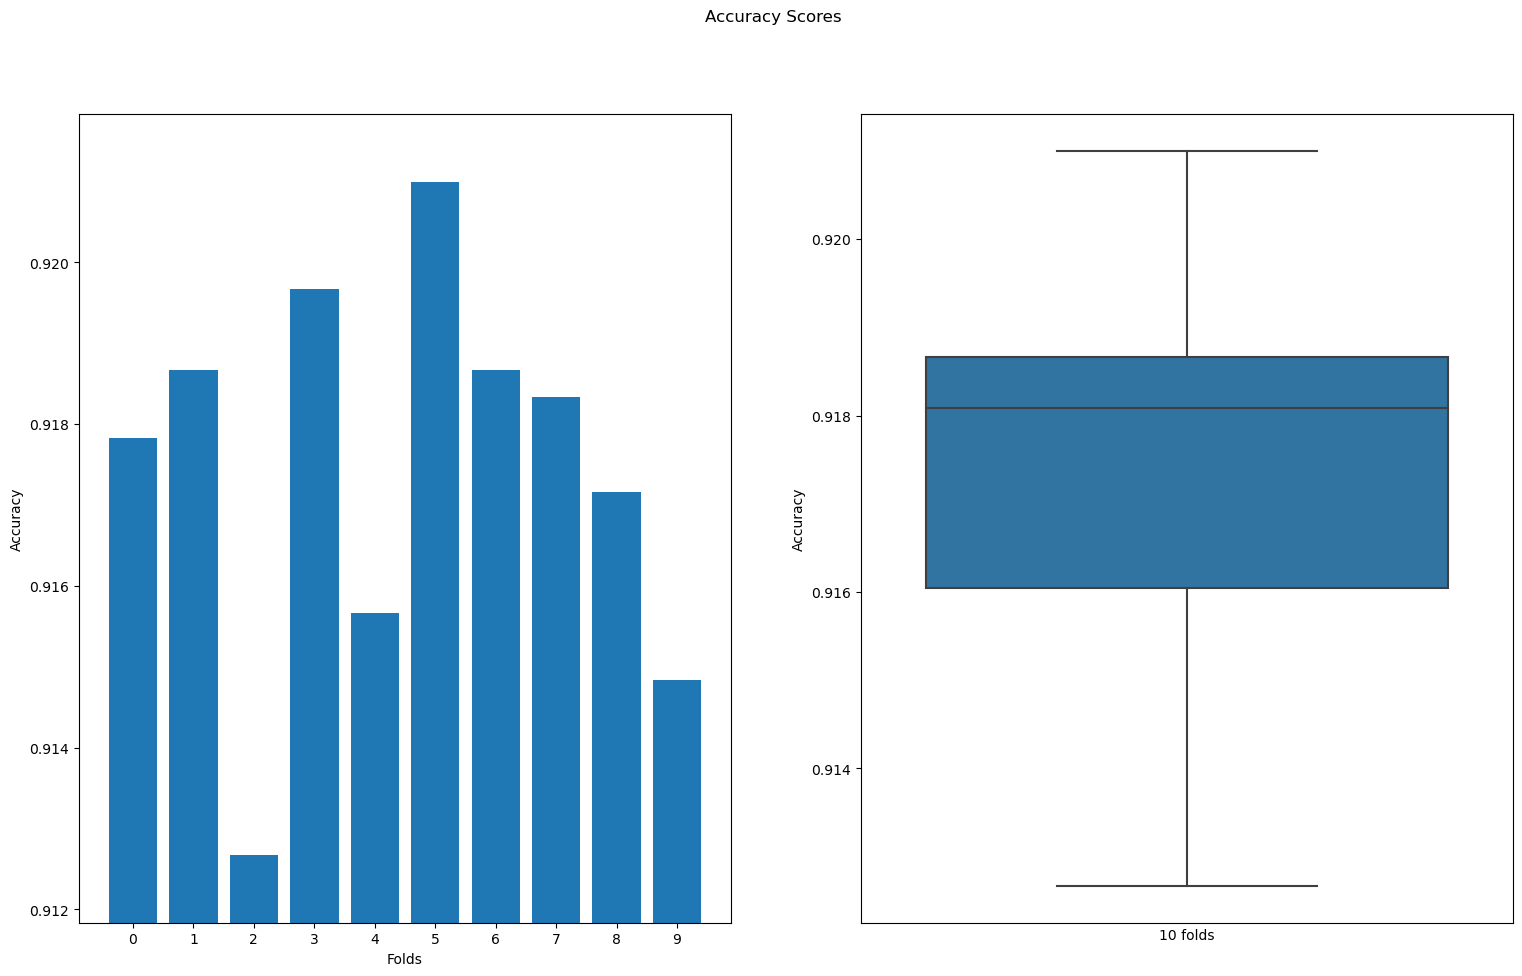

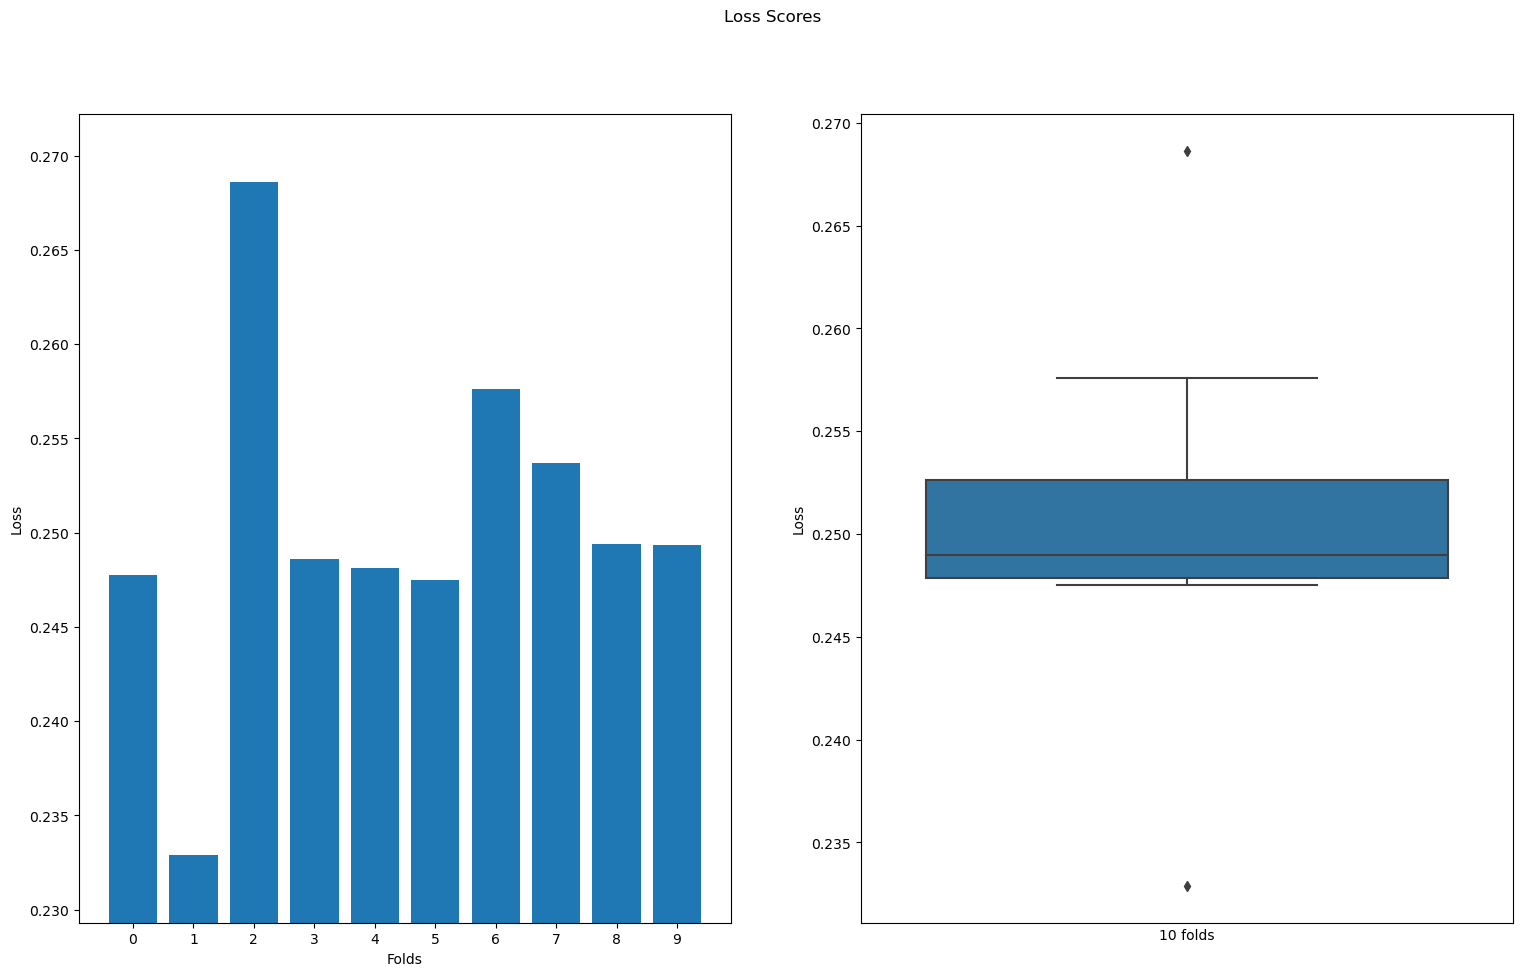

Average accuracy: 0.9174499928951263
Average loss: 0.2503499537706375


In [38]:
plot_k_fold_cross_validation_accuracy(all_acc)
plot_k_fold_cross_validation_loss(all_loss)

print(f"Average accuracy: {np.mean(all_acc)}")
print(f"Average loss: {np.mean(all_loss)}")

In [10]:
train_images_set = train_images[:(len(train_images)-(len(train_images)//5))]
train_labels_set = train_labels[:(len(train_labels)-(len(train_labels)//5))]

validation_images_set = train_images[(len(train_images)-(len(train_images)//5)):]
validation_labels_set = train_labels[(len(train_labels)-(len(train_labels)//5)):]

In [58]:
def plot_loss(history):
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_accuracy(history):
    val_acc = history.history['val_accuracy']
    acc = history.history['accuracy']
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss_and_accuracy(history):
    plot_loss(history)
    plot_accuracy(history)

Epoch 1/15
750/750 [==============================] - 8s 8ms/step - loss: 0.5728 - accuracy: 0.7914 - val_loss: 0.4243 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 5s 7ms/step - loss: 0.3601 - accuracy: 0.8696 - val_loss: 0.3466 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 5s 7ms/step - loss: 0.3049 - accuracy: 0.8891 - val_loss: 0.3017 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 6s 8ms/step - loss: 0.2748 - accuracy: 0.8987 - val_loss: 0.2905 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 7s 9ms/step - loss: 0.2513 - accuracy: 0.9076 - val_loss: 0.2632 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 5s 7ms/step - loss: 0.2128 - accuracy: 0.9226 - val_loss: 0.2569 - val_accuracy: 0.9082 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 5s 6ms/step 

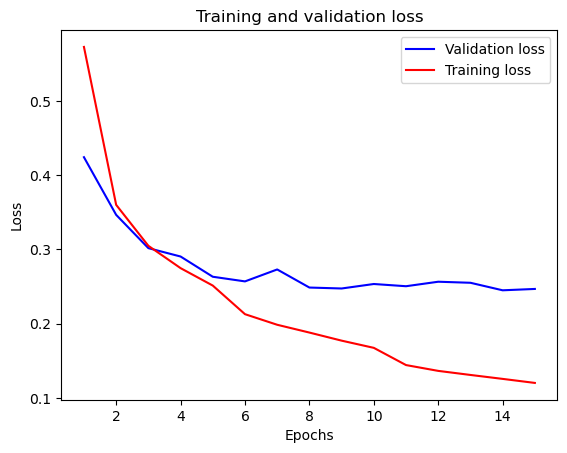

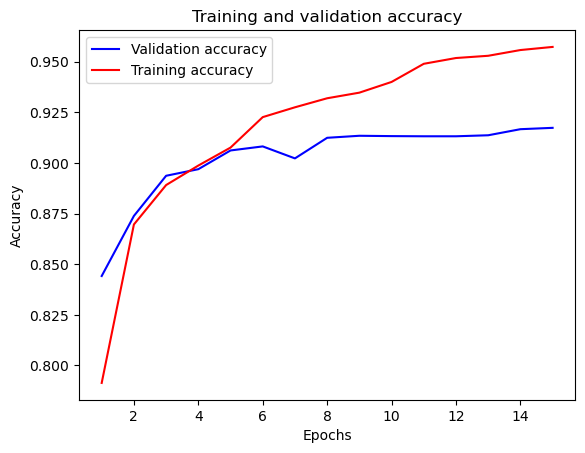

In [59]:
model_baseline = create_model()

def train_model(train_images, train_labels , model):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    history = model.fit(train_images, train_labels, validation_data=(validation_images_set, validation_labels_set), epochs=15, batch_size=64, callbacks=[callback])
    return model, history

model_baseline, history = train_model(train_images_set, train_labels_set, model_baseline)

test_loss, test_acc = model_baseline.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

In [60]:
model_baseline.save('model_baseline')

INFO:tensorflow:Assets written to: model_baseline/assets


INFO:tensorflow:Assets written to: model_baseline/assets


Epoch 1/15


2023-03-28 01:18:08.578782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


750/750 [==============================] - 6s 7ms/step - loss: 0.5860 - accuracy: 0.7860 - val_loss: 0.4209 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 5s 6ms/step - loss: 0.3818 - accuracy: 0.8608 - val_loss: 0.3577 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 5s 6ms/step - loss: 0.3313 - accuracy: 0.8810 - val_loss: 0.3214 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 5s 6ms/step - loss: 0.2997 - accuracy: 0.8895 - val_loss: 0.3105 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 5s 7ms/step - loss: 0.2753 - accuracy: 0.8995 - val_loss: 0.2833 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 5s 7ms/step - loss: 0.2362 - accuracy: 0.9140 - val_loss: 0.2659 - val_accuracy: 0.9054 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 5s 7ms/step - loss: 0.2

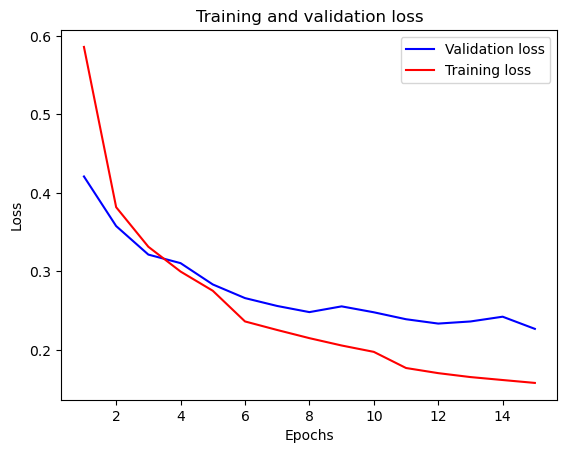

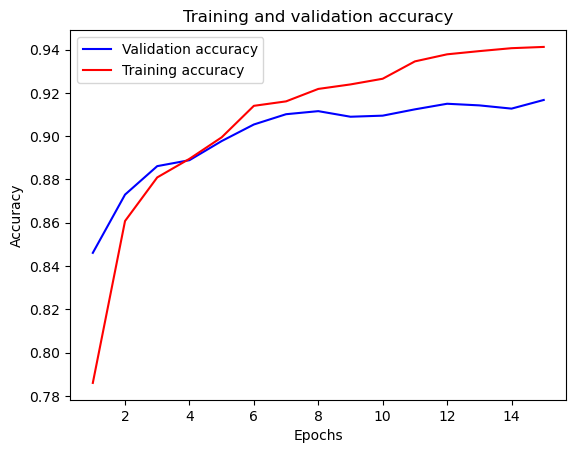

In [50]:
#Dropout inclussion after second maxpooling
#Dropout prevents overfitting by dropping a random weight (.5= 50% chance to happen)
#Dropout reduces correlation between neurons. It is added after second convolution layer before maxpolling since overfitting is most likely to happen there
def create_model_variant1():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model_v1 = create_model_variant1()

model_v1, history = train_model(train_images_set, train_labels_set, model_v1)

# Evaluate the model
test_loss, test_acc = model_v1.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: Dropout variant is both better than baseline on the test data and train data. A clear sign that the base model is slightly overfit.
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.2319 - accuracy: 0.9158 Variant1

In [61]:
model_v1.save('model_v1')

INFO:tensorflow:Assets written to: model_v1/assets


INFO:tensorflow:Assets written to: model_v1/assets


Epoch 1/15
750/750 [==============================] - 7s 8ms/step - loss: 1.1256 - accuracy: 0.7639 - val_loss: 0.7214 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 6s 8ms/step - loss: 0.6316 - accuracy: 0.8447 - val_loss: 0.5553 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 6s 8ms/step - loss: 0.5204 - accuracy: 0.8670 - val_loss: 0.4921 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 6s 8ms/step - loss: 0.4704 - accuracy: 0.8764 - val_loss: 0.4518 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 6s 8ms/step - loss: 0.4374 - accuracy: 0.8847 - val_loss: 0.4681 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 6s 8ms/step - loss: 0.3881 - accuracy: 0.8967 - val_loss: 0.3944 - val_accuracy: 0.8922 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 6s 8ms/step 

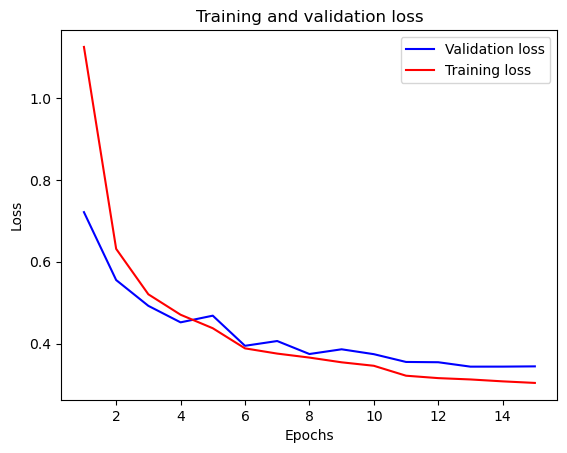

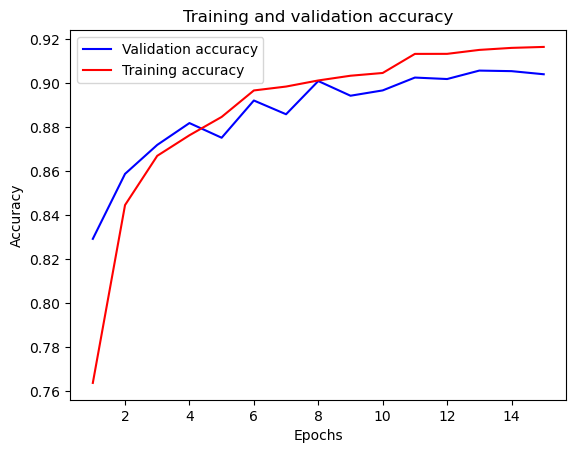

In [63]:
#L1 Regularization: Added to dense layers
#L1 prevents overfitting by making the model use more weights that are set to 0
def create_model_variant2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)),
        tf.keras.layers.Dense(10, activation='softmax' , kernel_regularizer=tf.keras.regularizers.l1(0.001))
    ])
    return model

model_v2 = create_model_variant2()

model_v2, history = train_model(train_images_set, train_labels_set, model_v2)

# Evaluate the model
test_loss, test_acc = model_v2.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: L1 performs better on the train data but has higher loss. This means its underfitting and will need more epochs to converge.
# In the test data it performs a bit worse than baseline.
# Different value for the strength could improve the results. In short it underfits compared to the baseline. Can't coverge fast enough in 15 epochs.
#Conclussion: loloss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.3358 - accuracy: 0.9046 Variant2

In [64]:
model_v2.save('model_v2')

INFO:tensorflow:Assets written to: model_v2/assets


INFO:tensorflow:Assets written to: model_v2/assets


Epoch 1/15
750/750 [==============================] - 8s 8ms/step - loss: 0.4521 - accuracy: 0.8362 - val_loss: 0.3650 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 5s 7ms/step - loss: 0.2988 - accuracy: 0.8915 - val_loss: 0.2827 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 5s 6ms/step - loss: 0.2519 - accuracy: 0.9077 - val_loss: 0.2848 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 5s 7ms/step - loss: 0.2244 - accuracy: 0.9183 - val_loss: 0.2989 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 5s 7ms/step - loss: 0.1999 - accuracy: 0.9258 - val_loss: 0.2653 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 5s 7ms/step - loss: 0.1461 - accuracy: 0.9462 - val_loss: 0.2809 - val_accuracy: 0.9053 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 5s 7ms/step 

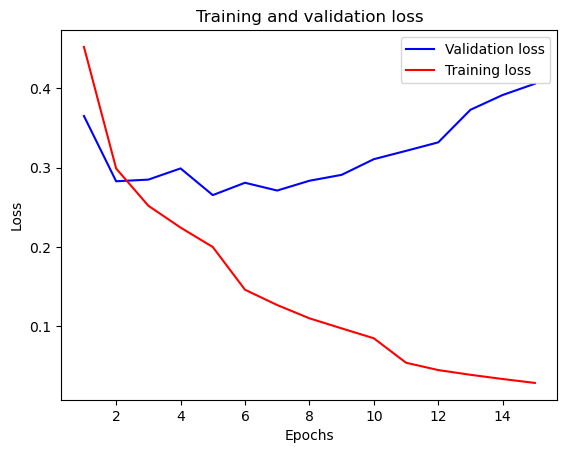

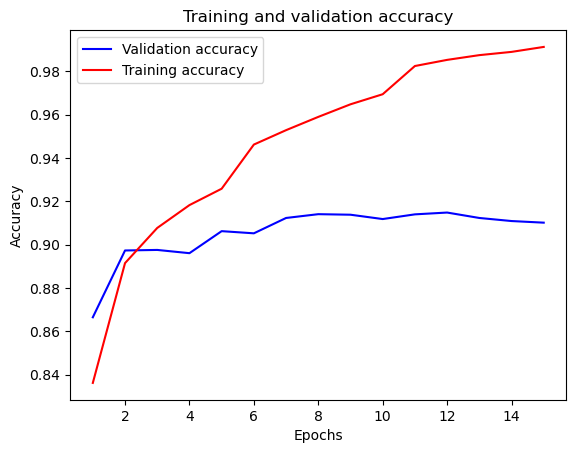

In [65]:
#Batch normalization: After first Conv2D layer 
#Stabilize learning process. Normalizes values to 0 or to 1 depending on whichever they are closer to using mean and std, solves internal covariate shift.
def create_model_variant3():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model_v3 = create_model_variant3()

model_v3, history = train_model(train_images_set, train_labels_set, model_v3)

# Evaluate the model
test_loss, test_acc = model_v3.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: Batch normalization trains excelently BUT will need more epochs to improve validation accuracy. Seems to overfit.
#This variant could also largely improve by adding a dropping layer and regulizers to reduce overfitting (but we can only have 1 change per variant).
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.4109 - accuracy: 0.9140 Variant3

In [66]:
model_v3.save('model_v3')

INFO:tensorflow:Assets written to: model_v3/assets


INFO:tensorflow:Assets written to: model_v3/assets


Epoch 1/15
750/750 [==============================] - 8s 9ms/step - loss: 0.6701 - accuracy: 0.7792 - val_loss: 0.4757 - val_accuracy: 0.8486 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 5s 7ms/step - loss: 0.4348 - accuracy: 0.8631 - val_loss: 0.4062 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 5s 7ms/step - loss: 0.3778 - accuracy: 0.8819 - val_loss: 0.3739 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 7s 9ms/step - loss: 0.3426 - accuracy: 0.8937 - val_loss: 0.3903 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 5s 7ms/step - loss: 0.3152 - accuracy: 0.9012 - val_loss: 0.3276 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - 6s 8ms/step - loss: 0.2804 - accuracy: 0.9132 - val_loss: 0.3319 - val_accuracy: 0.8917 - lr: 5.0000e-04
Epoch 7/15
750/750 [==============================] - 5s 7ms/step 

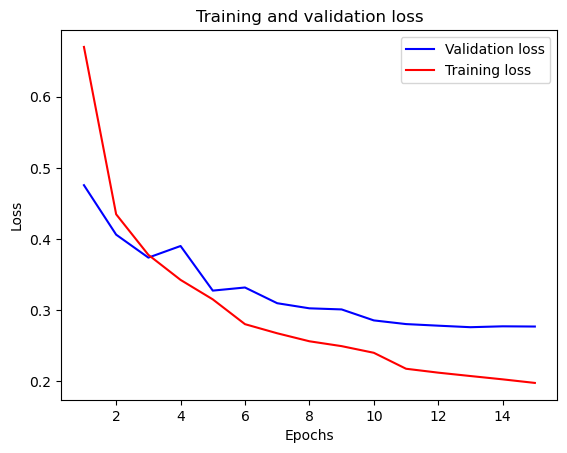

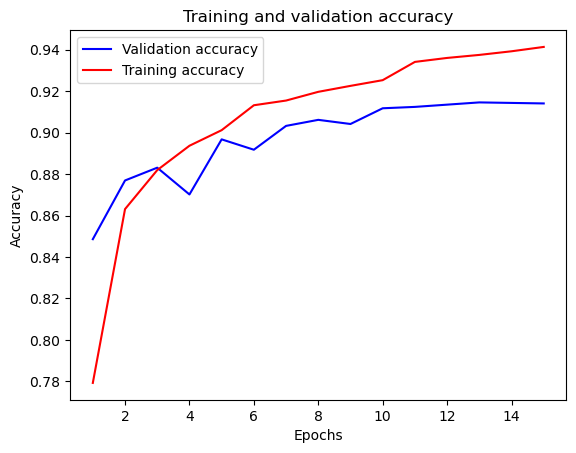

In [53]:
#L2 Regularization: Adding to dense layers
#L2 prevents overfitting by slowly melting large weight values, encourages model to use lower weights
def create_model_variant4():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    return model

model_v4 = create_model_variant4()

model_v4, history = train_model(train_images_set, train_labels_set, model_v4)

# Evaluate the model
test_loss, test_acc = model_v4.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plot_loss_and_accuracy(history)

#Result: L2 variant is a lot better than baseline on the train data but the accuracy seems better on the test data.
# It seems to converge faster however also appears to overfit since loss is higher on the test data.
#Conclussion: loss: 0.2490 - accuracy: 0.9146 Baseline - loss: 0.2698 - accuracy: 0.9173 Variant4

In [67]:
model_v4.save('model_v4')

INFO:tensorflow:Assets written to: model_v4/assets


INFO:tensorflow:Assets written to: model_v4/assets


In [54]:
#Two Best performing CNNs

model1Drop = create_model_variant1()
model2Batch = create_model_variant3()

model1Drop, historyDrop = train_model(train_images, train_labels, model1Drop)

model2Batch, historyBatch = train_model(train_images, train_labels, model2Batch)


Epoch 1/15


2023-03-28 01:23:46.178779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


938/938 [==============================] - 9s 9ms/step - loss: 0.5282 - accuracy: 0.8054 - val_loss: 0.3885 - val_accuracy: 0.8648 - lr: 0.0010
Epoch 2/15
938/938 [==============================] - 7s 8ms/step - loss: 0.3410 - accuracy: 0.8763 - val_loss: 0.3069 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 3/15
938/938 [==============================] - 7s 8ms/step - loss: 0.2954 - accuracy: 0.8925 - val_loss: 0.2782 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 4/15
938/938 [==============================] - 7s 8ms/step - loss: 0.2681 - accuracy: 0.9016 - val_loss: 0.2635 - val_accuracy: 0.9063 - lr: 0.0010
Epoch 5/15
938/938 [==============================] - 7s 8ms/step - loss: 0.2478 - accuracy: 0.9090 - val_loss: 0.2184 - val_accuracy: 0.9226 - lr: 0.0010
Epoch 6/15
938/938 [==============================] - 8s 8ms/step - loss: 0.2132 - accuracy: 0.9198 - val_loss: 0.1893 - val_accuracy: 0.9347 - lr: 5.0000e-04
Epoch 7/15
938/938 [==============================] - 7s 8ms/step - loss: 0.1

In [55]:
# Evaluate the model1
test_loss, test_acc = model1Drop.evaluate(test_images, test_labels, verbose=1)

print(f"model1Drop: Test accuracy: {test_acc}")
print(f"model1Drop: Test loss: {test_loss}")


# Evaluate the model2
test_loss, test_acc = model2Batch.evaluate(test_images, test_labels, verbose=1)

print(f"model2Batch: Test accuracy: {test_acc}")
print(f"model2Batch: Test loss: {test_loss}")

313/313 [==============================] - 1s 4ms/step - loss: 0.2212 - accuracy: 0.9206
Test accuracy: 0.9205999970436096
Test loss: 0.2212146669626236
313/313 [==============================] - 1s 4ms/step - loss: 0.4122 - accuracy: 0.9139
Test accuracy: 0.9139000177383423
Test loss: 0.4121916592121124


313/313 [==============================] - 1s 3ms/step
Normalized confusion matrix
[[0.887 0.    0.012 0.013 0.003 0.001 0.079 0.    0.005 0.   ]
 [0.001 0.979 0.001 0.014 0.    0.    0.004 0.    0.001 0.   ]
 [0.024 0.    0.866 0.008 0.045 0.    0.054 0.    0.003 0.   ]
 [0.008 0.002 0.006 0.933 0.024 0.    0.025 0.    0.002 0.   ]
 [0.001 0.    0.034 0.021 0.887 0.    0.055 0.    0.002 0.   ]
 [0.001 0.    0.    0.    0.    0.984 0.    0.009 0.    0.006]
 [0.129 0.001 0.04  0.019 0.057 0.    0.745 0.    0.009 0.   ]
 [0.    0.    0.    0.    0.    0.009 0.    0.964 0.    0.027]
 [0.003 0.    0.001 0.003 0.002 0.001 0.003 0.003 0.984 0.   ]
 [0.    0.    0.    0.    0.    0.004 0.001 0.018 0.    0.977]]


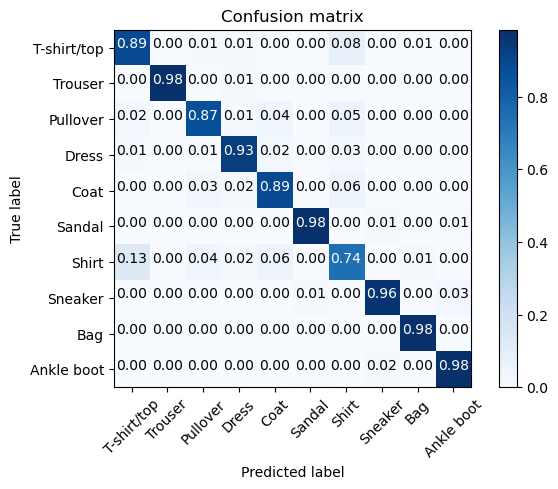

In [68]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_pred = model1Drop.predict(test_images)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = test_labels
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plot_confusion_matrix(confusion_mtx, class_names, normalize=True, title='Confusion matrix')